In [28]:
import os
from shutil import rmtree
import math
import random
from termcolor import colored
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import joblib
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from prepare_data import get_data
from sklearn.model_selection import train_test_split
from constant import CANDLES_HISTORY
from add_indicators import get_column_indicators

In [29]:
# if os.path.exists("resources/model"):
#     rmtree("resources/model")
# if os.path.exists("resources/parameters"):
#     rmtree("resources/parameters")
# if os.path.exists("logs/fit"):
#     rmtree("logs/fit")

In [15]:
def get_dataset(train_data):
    x_train = []
    for i in range(CANDLES_HISTORY, len(train_data)):
        x_train.append(train_data[i-CANDLES_HISTORY:i, :-1])
    return np.array(x_train)

In [16]:
def create_model(shape_examples, shape_features):
    print(colored('Generating LSTM model.', 'yellow'))
    print(colored(f'Shape {shape_examples}x{shape_features}', 'cyan'))

    model = Sequential()
    model.add(LSTM(
        units=5,
        return_sequences=True,
        input_shape=(shape_examples, shape_features)
    ))
    model.add(Dense(units=10))
    model.add(LSTM(units=5))
    model.add(Dense(units=10))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


In [27]:
try:
    df = pd.read_csv("resources/test.csv")
except FileNotFoundError:
    print(colored('Creating missing file.', 'red'))
    get_data()
    df = pd.read_csv("resources/test.csv")

df = df.iloc[48680:, :]
df.reset_index(inplace=True, drop=True)
df = df[["Close"] + get_column_indicators(df) + ["prediction"]]
df[(CANDLES_HISTORY - 5):(CANDLES_HISTORY + 5)]

,Close,SMA_20,SMA_5,RSI_20,STOCHk_20_3_3,STDEV_20,STOCHd_20_3_3,prediction
15,12089.05,12033.6015,12086.516,66.045518,96.882784,52.601900,96.272496,12083.31
16,12083.31,12041.0530,12086.546,64.318847,96.709672,48.159775,96.714588,12061.81
17,12061.81,12045.7830,12081.450,58.308480,89.932399,45.072177,94.508285,12062.10
18,12062.10,12050.5010,12077.062,58.363722,83.183422,41.249476,89.941831,12053.82
19,12053.82,12054.9190,12070.018,56.128528,75.258709,36.068309,82.791510,12055.94
20,12055.94,12058.5590,12063.396,56.576733,71.805256,31.872576,76.749129,12057.77
21,12057.77,12061.8080,12058.288,56.976121,68.091118,27.876893,71.718361,12054.40
22,12054.40,12065.0570,12056.806,55.978085,64.295406,22.206018,68.063927,12036.01
23,12036.01,12066.3195,12051.588,50.860529,52.334654,19.510758,61.573726,12038.90
24,12038.90,12066.9015,12048.604,51.592592,37.032538,18.427859,51.220866,12038.18


In [30]:
try:
    X = np.load('resources/parameters/X.npy')
    Y = np.load('resources/parameters/Y.npy')
    scaler = joblib.load("resources/parameters/scaler.save")
    print(colored('Loaded storaged data.', 'green'))
except FileNotFoundError:
    print(colored('Setting up parameters.', 'yellow'))
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df.values)

    if not os.path.exists("resources/parameters"):
        os.makedirs("resources/parameters")

    joblib.dump(scaler, "resources/parameters/scaler.save")
    X = get_dataset(scaled_data)
    Y = np.array(scaled_data[CANDLES_HISTORY:len(scaled_data), -1])
    np.save("resources/parameters/X.npy", X)
    np.save("resources/parameters/Y.npy", Y)
    print(colored('Parameters saved succesfully.', 'green'))


Setting up parameters.
Parameters saved succesfully.


In [31]:
check_split_df = pd.DataFrame(X[CANDLES_HISTORY])
check_split_df["prediction"] = Y[0:CANDLES_HISTORY]
check_split_df = scaler.inverse_transform(check_split_df.values)
check_split_df = pd.DataFrame(check_split_df)
print(check_split_df.loc[0].values)
print(df.loc[CANDLES_HISTORY].values)

all(check_split_df.loc[0].values.round() == df.loc[CANDLES_HISTORY].values.round())


[12055.94       12058.559      12063.396         56.5767326
    71.80525597    31.87257587    76.74912893 12057.77      ]
[12055.94       12058.559      12063.396         56.5767326
    71.80525597    31.87257587    76.74912893 12057.77      ]


True

In [32]:
print(colored(f'X shape: {X.shape}', 'yellow'))
print(colored(f'Y shape: {Y.shape}', 'yellow'))

training_data_len = math.ceil(len(Y) * .80)
x_train = X[:training_data_len]
y_train = Y[:training_data_len]
x_train = np.array(x_train)
y_train = np.array(y_train)

print(colored(f'X_train shape: {x_train.shape}', 'blue'))
print(colored(f'Y_train shape: {y_train.shape}', 'blue'))

divition = training_data_len # + (len(Y[training_data_len:]) / 5)
shrink = math.ceil(divition)
x_test = X[shrink:-1]
y_test = Y[shrink:-1]

zipped = list(zip(x_test, y_test))
random.shuffle(zipped)
x_test, y_test = zip(*zipped)

x_test = np.array(x_test)
y_test = np.array(y_test)

print(colored(f'X_test shape: {x_test.shape}', 'red'))
print(colored(f'Y_test shape: {y_test.shape}', 'red'))
print(colored(f'Shrink: {shrink}', 'red'))

print("-"*10)
print('test + train:', colored(
    (y_test.shape[0] + (shrink - y_train.shape[0])) + y_train.shape[0],
    'green' if (
        (
            y_test.shape[0] + (shrink - y_train.shape[0])
            + y_train.shape[0]
        ) == (Y.shape[0] - 1)
    ) else 'red'
))


X shape: (22007, 20, 7)
Y shape: (22007,)
X_train shape: (17606, 20, 7)
Y_train shape: (17606,)
X_test shape: (4400, 20, 7)
Y_test shape: (4400,)
Shrink: 17606
----------
test + train: 22006


In [66]:
try:
    model = load_model('resources/model/my_model_sequential.h5')
    print(colored('Model loaded successfully', 'green'))
except IOError:
    if not os.path.exists("resources/model"):
        os.makedirs("resources/model")
    print(colored('Training...', 'yellow'))
    model = create_model(X.shape[1], X.shape[-1])
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
    checkpoint = ModelCheckpoint(
        'resources/model/best_model_checkpoint.h5',
        monitor='val_loss',
        mode='min',
        verbose=1,
        save_best_only=True
    )
    log_dir = "logs/fit"
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    history = model.fit(
        x_train, y_train, batch_size=128, epochs=1000,
        validation_data=(x_test, y_test),
        callbacks=[checkpoint, tensorboard_callback, es]
    )

    model.save('resources/model/my_model_sequential.h5')
    hist_df = pd.DataFrame(history.history)
    with open('resources/model/history_sequential.csv', mode='w') as f:
        hist_df.to_csv(f)


Training...
Generating LSTM model.
Shape 20x5
Epoch 1/1000
134/135 [============================>.] - ETA: 0s - loss: 0.1483
Epoch 1: val_loss improved from inf to 0.01724, saving model to resources/model/best_model_checkpoint.h5
135/135 [==============================] - 15s 51ms/step - loss: 0.1478 - val_loss: 0.0172
Epoch 2/1000
135/135 [==============================] - ETA: 0s - loss: 0.0147
Epoch 2: val_loss improved from 0.01724 to 0.00263, saving model to resources/model/best_model_checkpoint.h5
135/135 [==============================] - 5s 40ms/step - loss: 0.0147 - val_loss: 0.0026
Epoch 3/1000
134/135 [============================>.] - ETA: 0s - loss: 0.0032
Epoch 3: val_loss improved from 0.00263 to 0.00227, saving model to resources/model/best_model_checkpoint.h5
135/135 [==============================] - 5s 35ms/step - loss: 0.0032 - val_loss: 0.0023
Epoch 4/1000
135/135 [==============================] - ETA: 0s - loss: 0.0020
Epoch 4: val_loss improved from 0.00227 to 0

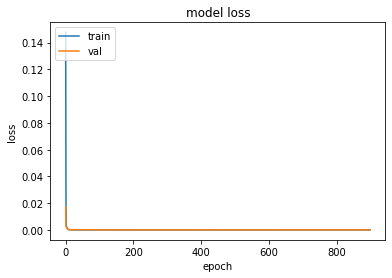

In [67]:
history = pd.read_csv("resources/model/history_sequential.csv")
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [68]:
train_acc = model.evaluate(x_train, y_train, verbose=0)
train_acc

4.271784200682305e-05

In [69]:
index = 8
sample = np.array([x_test[index]])

y_sample = scaler.inverse_transform([[y_test[index]] * 5 + [y_test[index]]])
print(y_sample[0][-1])
prediction = model.predict(sample)[0][0]
data = scaler.inverse_transform([[prediction] * 5 + [prediction]])
print(data[0][-1])
# print("train: ", mean_squared_error(y_train, prediction))


14665.29
1/1 [==============================] - 2s 2s/step
14669.86964257121
